In [1]:
import torch
import pickle
import os
from PIL import Image
from torch.nn.functional import softmax
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from IPython.utils import io
torch.set_printoptions(sci_mode=False)

## General Setup

In [2]:
import platform
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
os.chdir(f"{ROOT_PATH}/4_Assessor/Category_Assessor/DinoV2")
from helpers_pipeline import *
from helper_DinoV2_Embeddings import *
id2label = pickle.load(open("id2label_dicts/category_id2label.pkl", "rb"))
label2id = {v: k for k, v in id2label.items()}
os.chdir(current_wd)

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


In [4]:
set_seed(42)
dino_device, sg2_device, device = set_device()

Using devices: DinoV2 device: cpu | SG2 device: mps | General device: mps


## Fixed Models Setup

In [5]:
# Products data and latents
target_feature = 'category'
df, latents = load_latents(target_feature)
latents = latents.to(sg2_device)

# SG2-Ada Generator
G = setup_generator()
G = G.to(sg2_device)

# DinoV2 Model 
dino_processor, dino_model = setup_dinov2()
dino_model = dino_model.to(dino_device)

# Attribute Classifier Model
classifier = load_classifier()
classifier = classifier.to(device)

In [6]:
# Freeeze all non-relevant model weights and set to eval mode
for param in G.parameters():
    param.requires_grad = False
G.eval()
for param in dino_model.parameters():
    param.requires_grad = False
dino_model.eval()
for param in classifier.parameters():
    param.requires_grad = False
classifier.eval();


In [7]:
# Print devoce for each model: 
print(f"Generator: {next(G.parameters()).device} | Requires Grad: {next(G.parameters()).requires_grad}")
print(f"DinoV2: {next(dino_model.parameters()).device} | Requires Grad: {next(dino_model.parameters()).requires_grad}")
print(f"Classifier: {next(classifier.parameters()).device} | Requires Grad: {next(classifier.parameters()).requires_grad}")

Generator: mps:0 | Requires Grad: False
DinoV2: cpu | Requires Grad: False
Classifier: mps:0 | Requires Grad: False


In [8]:
def plot_generated(img):
    img_out = (img.permute(0,2,3,1)*127.5 + 128).clamp(0,255).to(torch.uint8)
    img_out = Image.fromarray(img_out[0].cpu().numpy())
    return img_out

### Test on small sample

Sample index: 13526
	Original Score: 1.82650161661968e-08 
	Target Score: 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.2499999701976776, Gradient Norm: 3.0359498026655274e-08, Score: 2.2958442258413925e-08


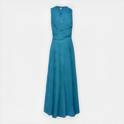

Sample index: 4426
	Original Score: 0.354348748922348 
	Target Score: 0.8543487787246704


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.0003071283281315118, Gradient Norm: 0.010390564799308777, Score: 0.8368237018585205


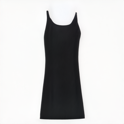

Sample index: 5578
	Original Score: 6.469594637792397e-09 
	Target Score: 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.25, Gradient Norm: 2.5892574750940867e-09, Score: 1.1366651619937329e-08


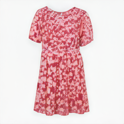

Sample index: 11636
	Original Score: 4.748433639178984e-05 
	Target Score: 0.500047504901886


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.24972699582576752, Gradient Norm: 0.002376242307946086, Score: 0.000320587947499007


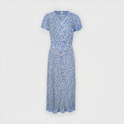

Sample index: 11363
	Original Score: 3.438289652990534e-10 
	Target Score: 0.5


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.24999994039535522, Gradient Norm: 5.019042959020226e-08, Score: 4.7322732399379674e-08


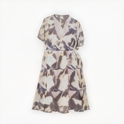

Sample index: 11111
	Original Score: 0.2069518268108368 
	Target Score: 0.7069518566131592


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.033236343413591385, Gradient Norm: 0.41133397817611694, Score: 0.8892602324485779


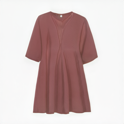

Sample index: 8322
	Original Score: 0.0013749620411545038 
	Target Score: 0.5013749599456787


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.25137487053871155, Gradient Norm: 3.083071351284161e-05, Score: 1.989061274798587e-06


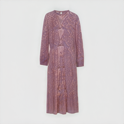

Sample index: 1685
	Original Score: 0.4272841513156891 
	Target Score: 0.9272841215133667


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 6.458811549236998e-05, Gradient Norm: 0.005951841827481985, Score: 0.9192474484443665


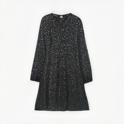

Sample index: 769
	Original Score: 0.10245218873023987 
	Target Score: 0.6024521589279175


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.0026360570918768644, Gradient Norm: 0.12463349848985672, Score: 0.6537947058677673


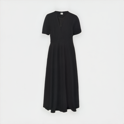

Sample index: 10583
	Original Score: 1.2435549479050678e-06 
	Target Score: 0.5000012516975403


  0%|          | 0/20 [00:00<?, ?it/s]

	Step 19: Loss: 0.24953366816043854, Gradient Norm: 0.002776764566078782, Score: 0.0004677943652495742


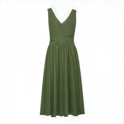

In [10]:
target_class = 1
num_refinement_steps = 20
num_train_samples = 10


directions = torch.zeros([8, 16, 512], device=device, requires_grad=True)
alpha = 0.5

optimizer = torch.optim.Adam([directions], lr=1e-2)
loss = nn.MSELoss(reduction='sum')

samples = np.random.choice(range(0,len(latents)), 10)
for sample in samples:
    print(f"Sample index: {sample}")
    latent = latents[sample]
    # Get class prediction for target class of unedited latent
    orig = G.synthesis(latent, noise_mode='const')
    orig_input_dino = dino_processor(orig).to(dino_device)
    orig_embedding = dino_model(orig_input_dino)['pooler_output'].to(device)
    orig_score = softmax(classifier(orig_embedding), dim = 1).squeeze(0)
    orig_score = orig_score[target_class]
    target_score = orig_score + alpha
    print(f"\tOriginal Score: {orig_score.item()} \n\tTarget Score: {target_score}")

    for i in tqdm(range(num_refinement_steps), leave = False):
        optimizer.zero_grad()
        new_latent = latent + alpha * directions[target_class]
        new_img = G.synthesis(new_latent, noise_mode='const')
        plot_img = plot_generated(new_img)
        input_dino = dino_processor(new_img).to(dino_device)
        embedding = dino_model(input_dino)['pooler_output'].to(device)
        score = softmax(classifier(embedding), dim = 1).squeeze(0)
        score = score[target_class]

        l = loss(target_score, score)
        l.backward()
        optimizer.step()
        if i == num_refinement_steps - 1:
            print(f"\tStep {i}: Loss: {l.item()}, Gradient Norm: {directions.grad.norm()}, Score: {score.item()}")
            display(plot_img.resize((124, 124)))

  0%|          | 0/10 [00:00<?, ?it/s]

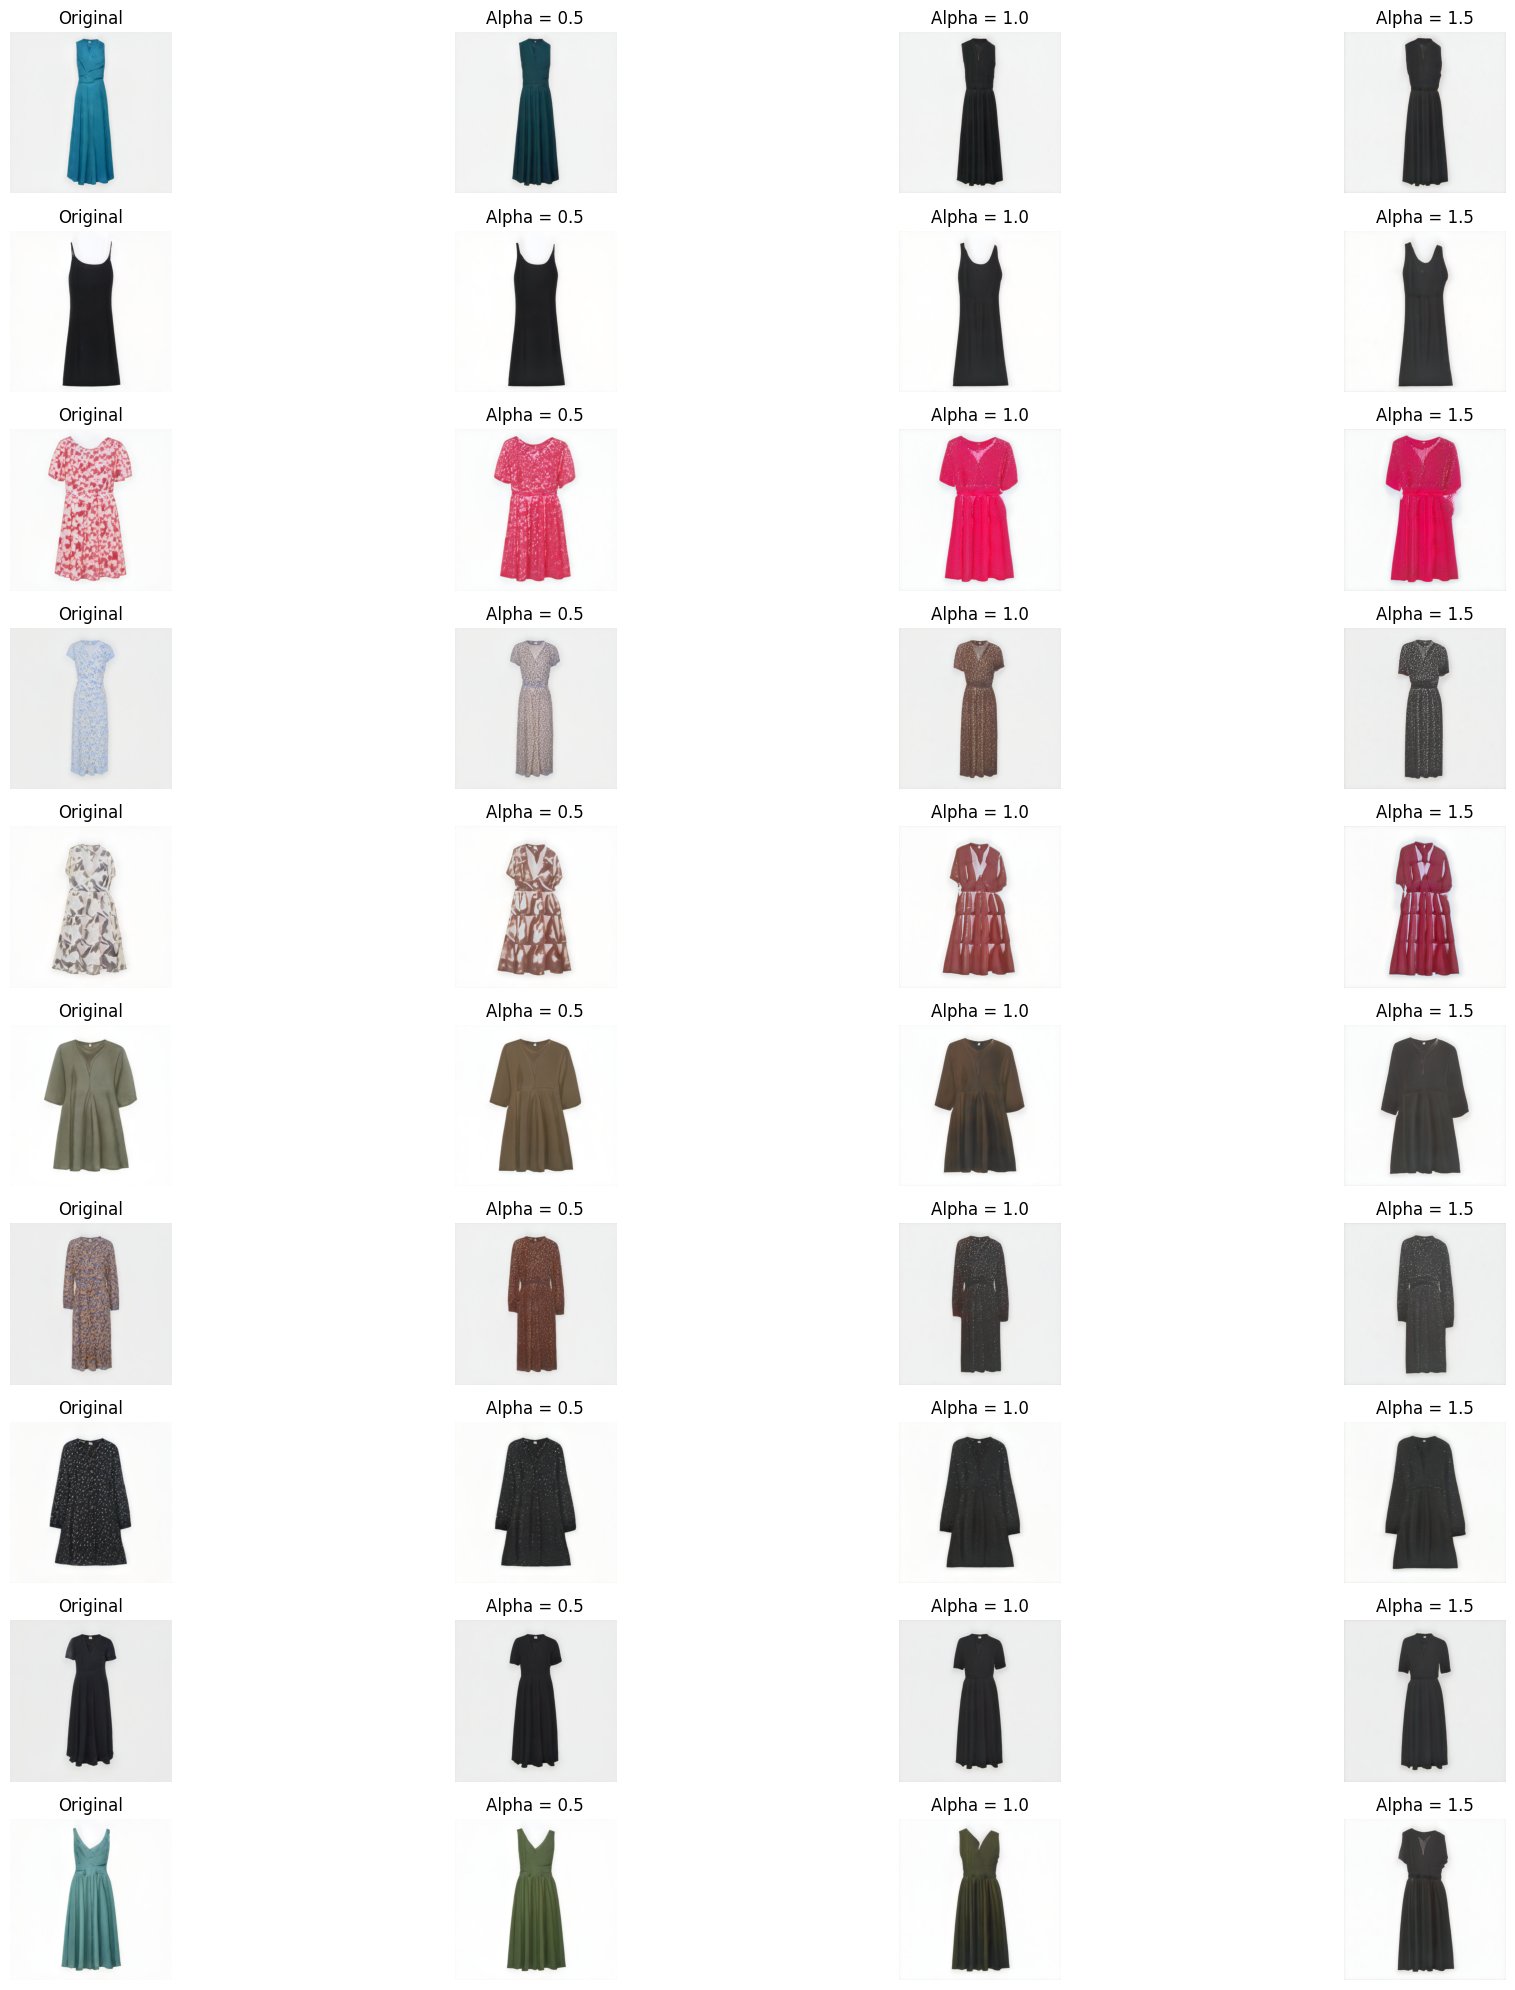

In [12]:
# Visualize samples and direction manipulations

fig, ax = plt.subplots(10, 4, figsize=(20, 20))
for i, sample in enumerate(tqdm(samples)):
    latent = latents[sample]
    orig_img = G.synthesis(latent, noise_mode='const')
    new_latent_1 = latent + 0.5 * directions[target_class]
    new_latent_2 = latent + 1.0 * directions[target_class]
    new_latent_3 = latent + 1.5 * directions[target_class]
    new_img_1 = G.synthesis(new_latent_1, noise_mode='const')
    new_img_2 = G.synthesis(new_latent_2, noise_mode='const')
    new_img_3 = G.synthesis(new_latent_3, noise_mode='const')

    ax[i, 0].imshow(plot_generated(orig_img))
    ax[i, 1].imshow(plot_generated(new_img_1))
    ax[i, 2].imshow(plot_generated(new_img_2))
    ax[i, 3].imshow(plot_generated(new_img_3))
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 3].axis('off')
    ax[i, 0].set_title(f"Original")
    ax[i, 1].set_title(f"Alpha = 0.5")
    ax[i, 2].set_title(f"Alpha = 1.0")
    ax[i, 3].set_title(f"Alpha = 1.5")
plt.tight_layout()
plt.show()

### Torch Model Class -> Needs to be fixed

In [ ]:
import torch
import torch.nn as nn
from torch.nn.functional import softmax
import numpy as np

class Editor(nn.Module):
    def __init__(self, generator, dino_model, dino_processor, classifier, id2label, label2id):
        super(Editor, self).__init__()
        self.generator = generator
        self.dino_model = dino_model
        self.dino_processor = dino_processor
        self.classifier = classifier

        self.id2label = id2label
        self.label2id = label2id   
        self.num_classes = len(id2label)
        self.directions = nn.Parameter(torch.zeros(self.num_classes, 16, 512), requires_grad=True)
        self.alphas = np.arange(0,1,0.1)

    def forward(self, latent, class_idx=None, alpha = None):
        if class_idx == None:
            class_idx = torch.randint(0, self.num_classes, (1,), device=self.directions.device)
        
        if alpha == None:
            alpha = torch.tensor(np.round(np.random.choice(self.alphas),2), device=latent.device, dtype=torch.float32)
            print(alpha)
        # Processing for real image
        with io.capture_output() as captured:
            real_img = self.generator.synthesis(latent, noise_mode='const')
        real_dino_input = self.dino_processor(real_img).to(dino_model.device)
        real_dino_embedding = self.dino_model(real_dino_input)['pooler_output'].to(latent.device)
        real_scores = self.classifier(real_dino_embedding)
        real_probs = softmax(real_scores, dim=1).squeeze(0)
        real_class_prob = real_probs[class_idx]

        # Processing for transformed image
        transformed_latent = latent + alpha * self.directions[class_idx].to(latent.device)
        with io.capture_output() as captured:
            transformed_img = self.generator.synthesis(transformed_latent, noise_mode='const')
        transformed_dino_input = self.dino_processor(transformed_img).to(dino_model.device)
        transformed_dino_embedding = self.dino_model(transformed_dino_input)['pooler_output'].to(latent.device)
        transformed_scores = self.classifier(transformed_dino_embedding)
        transformed_probs = softmax(transformed_scores, dim=1).squeeze(0)
        transformed_class_prob = transformed_probs[class_idx]

        return real_class_prob, transformed_class_prob, class_idx, alpha


In [ ]:
k = 9876

latent = latents[k]
display(df[df.latent_idx == k])
gen_img = G.synthesis(latent, noise_mode='const')
gen_img = plot_generated(gen_img)
display(gen_img)

In [ ]:
# Assuming all components are properly setup and moved to the correct device

latent = latents[k]

editor = Editor(G, dino_model, dino_processor, classifier, id2label, label2id)
optimizer = torch.optim.Adam(editor.parameters(), lr=0.5)
criterion = nn.MSELoss(reduction='sum')

for i in range(20):
    optimizer.zero_grad()
    real_class_prob, transformed_class_prob, class_idx, alpha = editor(latent, class_idx = 0, alpha=1)
    target = torch.tensor(1.0, device=latent.device, dtype=torch.float32)
    loss = criterion(target, transformed_class_prob)

    loss.backward()
    optimizer.step()
    print(f"Step {i} (class: {class_idx}, alpha:{alpha}): Loss: {loss.item()} | Directions gradient norm {editor.directions.grad.norm()} | Class prob of gen: {transformed_class_prob.item()}")
    transformed = latent + 1 * editor.directions[0].to(latent.device)
    out_img = plot_generated(G.synthesis(transformed, noise_mode='const'))
    display(out_img.resize([124, 124]))


In [ ]:
transformed_latent = latent + 1 * editor.directions[0].to(latent.device)
out_img = plot_generated(G.synthesis(transformed_latent, noise_mode='const')).resize([512, 512])
out_img

In [ ]:
# Test the classification: 
dino_input = dino_processor(G.synthesis(transformed_latent, noise_mode='const')).to(dino_model.device)
dino_embedding = dino_model(dino_input)['pooler_output'].to(device)
scores = classifier(dino_embedding)
probs = softmax(scores, dim=1).squeeze(0)
probs